# **Modeling and Evaluation**

## Objectives

This notebook focuses on training, optimizing, and evaluating a regression model that predicts the **sale price of houses** in Ames, Iowa. It is the core modeling step for **Business Requirement 2**, where the client wants to estimate property values based on known house attributes.

Key goals include:
- Selecting a subset of features that most strongly predict sale price
- Trying multiple regression models and choosing the most effective
- Evaluating the model using R², MAE, RMSE, and visualization
- Saving the model pipeline for deployment in the Streamlit app

## Inputs

- outputs\datasets\cleaned\TrainSetCleaned.csv
- outputs\datasets\cleaned\TestSetCleaned.csv

## Outputs

- `X_train.csv` and `X_test.csv`: Train/test sets with selected features
- `y_train.csv` and `y_test.csv`: Corresponding targets (SalePrice)
- Fitted regression pipeline (`best_regressor_pipeline.pkl`)
- Feature importance plot (`feature_importance.png`)
- Evaluation metrics and model summary


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with `os.getcwd()`

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Arthur\\OneDrive\\Documentos\\Code Institute\\PP5\\PP5-heritage-housing-issues-ml\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* `os.path.dirname()` gets the parent directory
* `os.chir()` defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
print("New working directory set to:", os.getcwd())

New working directory set to: c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml


---

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
      .drop(labels=['EnclosedPorch', 'WoodDeckSF'], axis=1)
  )

print(df.shape)
df.head(5)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


---

# ML Pipeline with all data

# Create ML Pipeline

We define a flexible and modular ML pipeline using `sklearn.pipeline`. This pipeline includes encoding, transformations, multicollinearity reduction, scaling, feature selection, and the model itself.

All transformation steps are based on decisions made in the Feature Engineering notebook, including:
- Ordinal encoding for 4 categorical features
- Log, power, and Yeo-Johnson transformations for skewed numeric features
- SmartCorrelatedSelection with threshold = 0.6

In [38]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.imputation import ArbitraryNumberImputer, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer, PowerTransformer, YeoJohnsonTransformer
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

def PipelineOptimization(model):
    num_impute_zero = ['2ndFlrSF', 'MasVnrArea', 'GarageYrBlt']
    num_impute_median = ['BedroomAbvGr', 'LotFrontage']
    cat_impute_missing = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish']
    ordinal_encode = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

    log_transform = ['GrLivArea']
    log10_transform = ['1stFlrSF']
    yeojohnson_transform = ['GarageArea', 'LotFrontage']
    power_transform = ['TotalBsmtSF']

    pipeline = Pipeline([
        ("num_zero", ArbitraryNumberImputer(arbitrary_number=0, variables=num_impute_zero)),
        ("num_median", MeanMedianImputer(imputation_method='median', variables=num_impute_median)),
        ("cat_missing", CategoricalImputer(imputation_method='missing', variables=cat_impute_missing)),

        ("ordinal_encoder", OrdinalEncoder(encoding_method='arbitrary', variables=ordinal_encode)),

        ("log_transform", LogTransformer(variables=log_transform)),
        ("log10_transform", LogTransformer(variables=log10_transform, base='10')),
        ("yeojohnson", YeoJohnsonTransformer(variables=yeojohnson_transform)),
        ("power_transform", PowerTransformer(variables=power_transform)),

        ("correlation_filter", SmartCorrelatedSelection(
            method='spearman',
            threshold=0.8,
            selection_method='variance')),
        
        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),
    ])

    return pipeline


Custom Class for hyperparameter optimisation

In [39]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


In [41]:
X_train.head(10)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,1828,0.0,NaN,Av,48,NaN,1774,774,Unf,2007.0,...,Gd,11694,90.0,452.0,108,5,9,1822,2007,2007
870,894,0.0,2.0,No,0,Unf,894,308,NaN,1962.0,...,TA,6600,60.0,0.0,0,5,5,894,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,432,Unf,1921.0,...,TA,13360,80.0,0.0,0,7,5,876,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,857,RFn,2002.0,...,Gd,13265,NaN,148.0,59,5,8,1568,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,843,RFn,2001.0,...,Gd,13704,118.0,150.0,81,5,7,1541,2001,2002
1454,1221,0.0,2.0,No,410,GLQ,811,400,RFn,2004.0,...,Gd,7500,62.0,0.0,113,5,7,1221,2004,2005
40,1324,0.0,3.0,No,643,Rec,445,440,NaN,1965.0,...,TA,8658,84.0,101.0,138,5,6,1088,1965,1965
959,696,720.0,3.0,No,604,ALQ,92,484,Unf,1999.0,...,Gd,2572,24.0,0.0,44,5,7,696,1999,1999
75,526,462.0,2.0,Gd,462,GLQ,0,297,Unf,1973.0,...,TA,1596,21.0,0.0,101,5,4,462,1973,1973
1389,869,349.0,3.0,No,375,ALQ,360,440,Unf,2003.0,...,TA,6000,60.0,0.0,0,6,6,735,1941,1950


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [43]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

Check results

In [44]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.652948,0.79335,0.863188,0.080252
0,LinearRegression,0.71528,0.786332,0.838684,0.047219
2,RandomForestRegressor,0.688763,0.781007,0.832813,0.053781
5,GradientBoostingRegressor,0.612449,0.764207,0.831192,0.079159
4,AdaBoostRegressor,0.670662,0.752351,0.777966,0.041251
6,XGBRegressor,0.516448,0.648972,0.751455,0.087389
1,DecisionTreeRegressor,0.494971,0.579547,0.667303,0.063698


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [49]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=0)
}

params_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
    },
    "LinearRegression": {
        'model__fit_intercept': [True],
    },
    "RandomForestRegressor": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
    }
}

Extensive GridSearch CV

In [50]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

Check results

In [51]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__fit_intercept
6,ExtraTreesRegressor,0.751059,0.828772,0.86795,0.042633,10,2,5,100,NaN
7,ExtraTreesRegressor,0.751268,0.828424,0.869735,0.042461,10,2,5,200,NaN
14,ExtraTreesRegressor,0.753337,0.827936,0.871126,0.043077,20,2,5,100,NaN
15,ExtraTreesRegressor,0.754187,0.827768,0.870543,0.042365,20,2,5,200,NaN
5,ExtraTreesRegressor,0.747517,0.826413,0.870747,0.044117,10,2,2,200,NaN
13,ExtraTreesRegressor,0.747944,0.826035,0.867795,0.044124,20,2,2,200,NaN
4,ExtraTreesRegressor,0.743336,0.824036,0.869741,0.045152,10,2,2,100,NaN
12,ExtraTreesRegressor,0.741375,0.823475,0.866555,0.04605,20,2,2,100,NaN
3,ExtraTreesRegressor,0.705349,0.813308,0.869487,0.060819,10,1,5,200,NaN
2,ExtraTreesRegressor,0.701839,0.812232,0.869268,0.062245,10,1,5,100,NaN


Check the best model

In [52]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

Parameters for best model

In [53]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 10,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 5,
 'model__n_estimators': 100}

Define the best regressor

In [54]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('num_zero',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea',
                                                   'GarageYrBlt'])),
                ('num_median',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'LotFrontage'])),
                ('cat_missing',
                 CategoricalImputer(variables=['BsmtExposure', 'BsmtFinType1',
                                               'GarageFinish'])),
                ('ordinal_encoder',
                 OrdinalEncoder(encoding_method='arbitrary...
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('correlation_filter',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance')),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=10, min_samples_leaf=2,
                                     min_samples_split=5, random_state=0))])

## Assess feature importance

c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'GarageArea', 'YearRemodAdd', 'TotalBsmtSF']


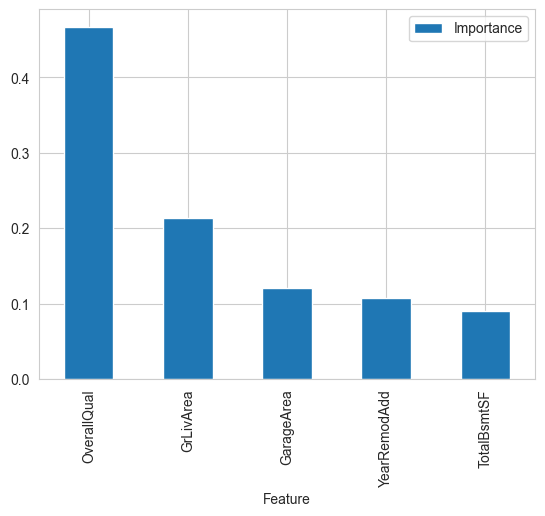

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 9
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Regressor on Train and Tests Sets

In [56]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.935
Mean Absolute Error: 13689.005
Mean Squared Error: 402706877.626
Root Mean Squared Error: 20067.558


* Test Set
R2 Score: 0.84
Mean Absolute Error: 19925.137
Mean Squared Error: 1106400548.055
Root Mean Squared Error: 33262.6




c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\imputation\categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml\.venv\Lib\site-packages\feature_engine\encoding\base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

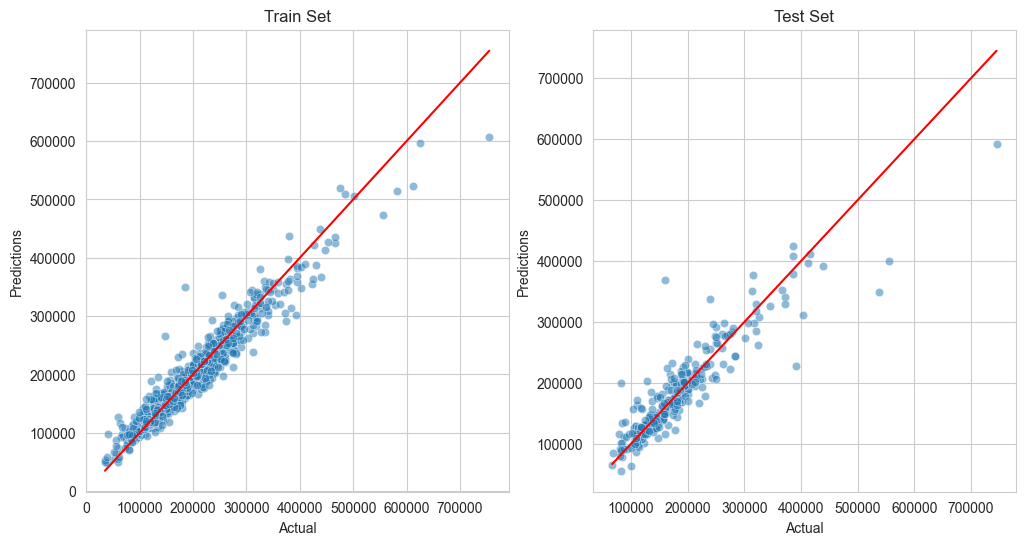

In [57]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)